In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:54 - loss: 0.0467 - STD: 1.7110e-04 - MAE: 0.2074

 4/74 [>.............................] - ETA: 2s - loss: 0.0292 - STD: 2.6666e-04 - MAE: 0.1307  

 5/74 [=>............................] - ETA: 2s - loss: 0.0293 - STD: 2.4364e-04 - MAE: 0.1313

 6/74 [=>............................] - ETA: 3s - loss: 0.0284 - STD: 2.2896e-04 - MAE: 0.1284

 7/74 [=>............................] - ETA: 3s - loss: 0.0270 - STD: 2.2524e-04 - MAE: 0.1228

 8/74 [==>...........................] - ETA: 3s - loss: 0.0253 - STD: 2.3142e-04 - MAE: 0.1151

 9/74 [==>...........................] - ETA: 3s - loss: 0.0239 - STD: 2.4408e-04 - MAE: 0.1099

10/74 [===>..........................] - ETA: 3s - loss: 0.0228 - STD: 2.5991e-04 - MAE: 0.1085

11/74 [===>..........................] - ETA: 3s - loss: 0.0223 - STD: 2.7742e-04 - MAE: 0.1091

12/74 [===>..........................] - ETA: 3s - loss: 0.0220 - STD: 2.9451e-04 - MAE: 0.1102

13/74 [====>.........................] - ETA: 3s - loss: 0.0216 - STD: 3.1106e-04 - MAE: 0.1106

14/74 [====>.........................] - ETA: 3s - loss: 0.0210 - STD: 3.2623e-04 - MAE: 0.1097

15/74 [=====>........................] - ETA: 3s - loss: 0.0205 - STD: 3.3984e-04 - MAE: 0.1077

16/74 [=====>........................] - ETA: 3s - loss: 0.0200 - STD: 3.5164e-04 - MAE: 0.1051

17/74 [=====>........................] - ETA: 3s - loss: 0.0195 - STD: 3.6178e-04 - MAE: 0.1024

18/74 [======>.......................] - ETA: 3s - loss: 0.0191 - STD: 3.7077e-04 - MAE: 0.1000

19/74 [======>.......................] - ETA: 3s - loss: 0.0189 - STD: 3.7935e-04 - MAE: 0.0981

20/74 [=======>......................] - ETA: 3s - loss: 0.0187 - STD: 3.8820e-04 - MAE: 0.0964

21/74 [=======>......................] - ETA: 3s - loss: 0.0185 - STD: 3.9769e-04 - MAE: 0.0948

22/74 [=======>......................] - ETA: 4s - loss: 0.0184 - STD: 4.0819e-04 - MAE: 0.0933

25/74 [=========>....................] - ETA: 4s - loss: 0.0176 - STD: 4.4898e-04 - MAE: 0.0899

27/74 [=========>....................] - ETA: 3s - loss: 0.0172 - STD: 4.8146e-04 - MAE: 0.0894

28/74 [==========>...................] - ETA: 3s - loss: 0.0171 - STD: 4.9863e-04 - MAE: 0.0894

29/74 [==========>...................] - ETA: 3s - loss: 0.0169 - STD: 5.1590e-04 - MAE: 0.0894

30/74 [===========>..................] - ETA: 3s - loss: 0.0168 - STD: 5.3278e-04 - MAE: 0.0892

31/74 [===========>..................] - ETA: 3s - loss: 0.0166 - STD: 5.4965e-04 - MAE: 0.0888

32/74 [===========>..................] - ETA: 3s - loss: 0.0165 - STD: 5.6599e-04 - MAE: 0.0883

33/74 [============>.................] - ETA: 3s - loss: 0.0163 - STD: 5.8185e-04 - MAE: 0.0876

34/74 [============>.................] - ETA: 3s - loss: 0.0162 - STD: 5.9755e-04 - MAE: 0.0869

35/74 [=============>................] - ETA: 3s - loss: 0.0161 - STD: 6.1337e-04 - MAE: 0.0862

36/74 [=============>................] - ETA: 2s - loss: 0.0160 - STD: 6.2996e-04 - MAE: 0.0855

37/74 [==============>...............] - ETA: 2s - loss: 0.0159 - STD: 6.4698e-04 - MAE: 0.0848

38/74 [==============>...............] - ETA: 2s - loss: 0.0158 - STD: 6.6532e-04 - MAE: 0.0842

39/74 [==============>...............] - ETA: 2s - loss: 0.0157 - STD: 6.8468e-04 - MAE: 0.0837

40/74 [===============>..............] - ETA: 2s - loss: 0.0156 - STD: 7.0579e-04 - MAE: 0.0833

41/74 [===============>..............] - ETA: 2s - loss: 0.0155 - STD: 7.2833e-04 - MAE: 0.0830

42/74 [================>.............] - ETA: 2s - loss: 0.0155 - STD: 7.5312e-04 - MAE: 0.0828

43/74 [================>.............] - ETA: 2s - loss: 0.0154 - STD: 7.7914e-04 - MAE: 0.0826

44/74 [================>.............] - ETA: 2s - loss: 0.0153 - STD: 8.0598e-04 - MAE: 0.0825

45/74 [=================>............] - ETA: 2s - loss: 0.0152 - STD: 8.3410e-04 - MAE: 0.0823

46/74 [=================>............] - ETA: 2s - loss: 0.0151 - STD: 8.6321e-04 - MAE: 0.0822

47/74 [==================>...........] - ETA: 2s - loss: 0.0151 - STD: 8.9293e-04 - MAE: 0.0820

48/74 [==================>...........] - ETA: 1s - loss: 0.0150 - STD: 9.2389e-04 - MAE: 0.0817

49/74 [==================>...........] - ETA: 1s - loss: 0.0149 - STD: 9.5560e-04 - MAE: 0.0814

50/74 [===================>..........] - ETA: 1s - loss: 0.0149 - STD: 9.8837e-04 - MAE: 0.0810

51/74 [===================>..........] - ETA: 1s - loss: 0.0148 - STD: 0.0010 - MAE: 0.0807    

52/74 [====================>.........] - ETA: 1s - loss: 0.0147 - STD: 0.0011 - MAE: 0.0803

53/74 [====================>.........] - ETA: 1s - loss: 0.0147 - STD: 0.0011 - MAE: 0.0800

54/74 [====================>.........] - ETA: 1s - loss: 0.0146 - STD: 0.0011 - MAE: 0.0797

55/74 [=====================>........] - ETA: 1s - loss: 0.0146 - STD: 0.0012 - MAE: 0.0794

56/74 [=====================>........] - ETA: 1s - loss: 0.0145 - STD: 0.0012 - MAE: 0.0792

57/74 [======================>.......] - ETA: 1s - loss: 0.0144 - STD: 0.0013 - MAE: 0.0790

58/74 [======================>.......] - ETA: 1s - loss: 0.0144 - STD: 0.0013 - MAE: 0.0789

59/74 [======================>.......] - ETA: 1s - loss: 0.0143 - STD: 0.0014 - MAE: 0.0788

60/74 [=======================>......] - ETA: 1s - loss: 0.0143 - STD: 0.0015 - MAE: 0.0786

61/74 [=======================>......] - ETA: 0s - loss: 0.0143 - STD: 0.0015 - MAE: 0.0785

62/74 [========================>.....] - ETA: 0s - loss: 0.0142 - STD: 0.0016 - MAE: 0.0783

63/74 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 0.0017 - MAE: 0.0781

64/74 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 0.0018 - MAE: 0.0779

65/74 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.0018 - MAE: 0.0777

66/74 [=========================>....] - ETA: 0s - loss: 0.0140 - STD: 0.0019 - MAE: 0.0775

67/74 [==========================>...] - ETA: 0s - loss: 0.0140 - STD: 0.0020 - MAE: 0.0773

68/74 [==========================>...] - ETA: 0s - loss: 0.0139 - STD: 0.0022 - MAE: 0.0771

69/74 [==========================>...] - ETA: 0s - loss: 0.0139 - STD: 0.0023 - MAE: 0.0770

70/74 [===========================>..] - ETA: 0s - loss: 0.0138 - STD: 0.0024 - MAE: 0.0768

71/74 [===========================>..] - ETA: 0s - loss: 0.0138 - STD: 0.0025 - MAE: 0.0767

72/74 [============================>.] - ETA: 0s - loss: 0.0138 - STD: 0.0027 - MAE: 0.0765

73/74 [============================>.] - ETA: 0s - loss: 0.0137 - STD: 0.0029 - MAE: 0.0764

74/74 [==============================] - ETA: 0s - loss: 0.0136 - STD: 0.0030 - MAE: 0.0762

74/74 [==============================] - 8s 82ms/step - loss: 0.0136 - STD: 0.0030 - MAE: 0.0762 - val_loss: 0.0118 - val_STD: 0.0120 - val_MAE: 0.0640


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0102 - STD: 0.0175 - MAE: 0.0624

 2/74 [..............................] - ETA: 5s - loss: 0.0099 - STD: 0.0181 - MAE: 0.0610

 3/74 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 0.0189 - MAE: 0.0599

 4/74 [>.............................] - ETA: 4s - loss: 0.0096 - STD: 0.0199 - MAE: 0.0593

 5/74 [=>............................] - ETA: 4s - loss: 0.0095 - STD: 0.0209 - MAE: 0.0589

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 0.0220 - MAE: 0.0587

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 0.0232 - MAE: 0.0586

 8/74 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 0.0245 - MAE: 0.0585

 9/74 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.0259 - MAE: 0.0583

10/74 [===>..........................] - ETA: 4s - loss: 0.0089 - STD: 0.0273 - MAE: 0.0579

11/74 [===>..........................] - ETA: 4s - loss: 0.0087 - STD: 0.0286 - MAE: 0.0573

12/74 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.0300 - MAE: 0.0567

13/74 [====>.........................] - ETA: 4s - loss: 0.0084 - STD: 0.0314 - MAE: 0.0563

14/74 [====>.........................] - ETA: 4s - loss: 0.0083 - STD: 0.0328 - MAE: 0.0557

15/74 [=====>........................] - ETA: 3s - loss: 0.0081 - STD: 0.0344 - MAE: 0.0553

16/74 [=====>........................] - ETA: 3s - loss: 0.0080 - STD: 0.0361 - MAE: 0.0549

17/74 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0377 - MAE: 0.0545

18/74 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0393 - MAE: 0.0541

19/74 [======>.......................] - ETA: 3s - loss: 0.0076 - STD: 0.0410 - MAE: 0.0537

20/74 [=======>......................] - ETA: 3s - loss: 0.0075 - STD: 0.0424 - MAE: 0.0533

21/74 [=======>......................] - ETA: 3s - loss: 0.0073 - STD: 0.0439 - MAE: 0.0528

22/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0452 - MAE: 0.0524

24/74 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0480 - MAE: 0.0516

25/74 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0493 - MAE: 0.0513

26/74 [=========>....................] - ETA: 3s - loss: 0.0068 - STD: 0.0507 - MAE: 0.0509

27/74 [=========>....................] - ETA: 3s - loss: 0.0067 - STD: 0.0519 - MAE: 0.0505

28/74 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0529 - MAE: 0.0501

29/74 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.0540 - MAE: 0.0497

30/74 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0550 - MAE: 0.0493

31/74 [===========>..................] - ETA: 2s - loss: 0.0063 - STD: 0.0561 - MAE: 0.0490

32/74 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0572 - MAE: 0.0487

33/74 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0484

34/74 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0592 - MAE: 0.0481

35/74 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0600 - MAE: 0.0478

36/74 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0475

37/74 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0618 - MAE: 0.0472

38/74 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0627 - MAE: 0.0470

39/74 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0467

40/74 [===============>..............] - ETA: 2s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0465

41/74 [===============>..............] - ETA: 2s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0462

42/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0460

43/74 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0456

45/74 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0454

46/74 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0452

47/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0450

48/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0448

49/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0700 - MAE: 0.0446

50/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0705 - MAE: 0.0444

51/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0709 - MAE: 0.0443

52/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0714 - MAE: 0.0441

53/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0719 - MAE: 0.0439

54/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0723 - MAE: 0.0438

55/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0727 - MAE: 0.0436

56/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0731 - MAE: 0.0434

57/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0735 - MAE: 0.0433

58/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0738 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0746 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0755 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0413

74/74 [==============================] - 5s 68ms/step - loss: 0.0044 - STD: 0.0784 - MAE: 0.0413 - val_loss: 0.0028 - val_STD: 0.0664 - val_MAE: 0.0329


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0989 - MAE: 0.0346

 2/74 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0344

 3/74 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0940 - MAE: 0.0343

 4/74 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0341

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0342

 6/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0342

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0342

 8/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0342

 9/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0342

10/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0342

11/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0341

12/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0341

13/74 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0953 - MAE: 0.0341

14/74 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0342

15/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0341

16/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0341

17/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0340

18/74 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0340

19/74 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0340

20/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0340

21/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0340

22/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0340

23/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0340

24/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0339

25/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0339

26/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0339

27/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0338

28/74 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0338

29/74 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0338

30/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0337

31/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0337

32/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0337

33/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0336

34/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0336

35/74 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0337

36/74 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0336

37/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0336

38/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0336

39/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

40/74 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

41/74 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

42/74 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

43/74 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

44/74 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

45/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

46/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0959 - MAE: 0.0334

47/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

48/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

49/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0333

50/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0333

51/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0333

52/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0333

53/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0332

54/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0332

55/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

56/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0332

57/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0332

58/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0331

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0331

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0331

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

63/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0331

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0330

65/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

69/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

71/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

74/74 [==============================] - 5s 69ms/step - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329 - val_loss: 0.0031 - val_STD: 0.0668 - val_MAE: 0.0317


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0920 - MAE: 0.0316

 2/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0312

 3/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0313

 4/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0314

 5/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0314

 6/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0962 - MAE: 0.0314

 7/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0962 - MAE: 0.0314

 8/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0314

 9/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0313

10/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0314

11/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0314

12/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0314

13/74 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0315

14/74 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0315

15/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0315

16/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0314

17/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0314

18/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0314

19/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0314

20/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0314

21/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

22/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0314

23/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

24/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

25/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0313

26/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0313

27/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

28/74 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

29/74 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

30/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

31/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

32/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

33/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

34/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

35/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

36/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

37/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

38/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0312

39/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

40/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

41/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0312

42/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

43/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

44/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

45/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

46/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0312

47/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

48/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

49/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

50/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

51/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

52/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

53/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

54/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

55/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

57/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0310

58/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0310

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0310

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

74/74 [==============================] - 5s 68ms/step - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308 - val_loss: 0.0029 - val_STD: 0.0701 - val_MAE: 0.0311


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0297

 2/74 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0300

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0299

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

14/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0299

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

29/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0298

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0298

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

41/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

44/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0299

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0299

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

59/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0299

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0299

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

65/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

74/74 [==============================] - 5s 70ms/step - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298 - val_loss: 0.0027 - val_STD: 0.0737 - val_MAE: 0.0318


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 2/74 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0296

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0295

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0295

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0296

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

12/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

13/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0299

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0300

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0300

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0300

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0300

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0300

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0300

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0298

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0298

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0298

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0294

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0294

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0294

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0294

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0293

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

74/74 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293 - val_loss: 0.0027 - val_STD: 0.0735 - val_MAE: 0.0310


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0977 - MAE: 0.0291

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0296

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0976 - MAE: 0.0293

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0292

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0295

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0294

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0293

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0293

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0294

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0294

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0293

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0293

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0293

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0292

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0292

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0292

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0293

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0293

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0292

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0292

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0292

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0292

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289 - val_loss: 0.0026 - val_STD: 0.0735 - val_MAE: 0.0312


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0987 - MAE: 0.0289

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0285

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0295

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0294

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0294

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0296

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0297

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0297

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0298

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0298

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0297

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0298

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0298

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0297

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0297

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0297

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0296

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0296

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0296

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0295

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0295

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0295

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0294

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0294

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0294

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0293

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0293

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0293

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0293

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0292

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0292

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0292

44/74 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0292

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0292

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0291

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0291

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289 - val_loss: 0.0026 - val_STD: 0.0769 - val_MAE: 0.0326


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0311

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0294

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0292

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0293

 7/74 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

 8/74 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0293

 9/74 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0294

10/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0292

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0286

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0286

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

27/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

74/74 [==============================] - 5s 68ms/step - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284 - val_loss: 0.0026 - val_STD: 0.0755 - val_MAE: 0.0305


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0280

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0280

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0283

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0288

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0290

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0290

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

27/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

43/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285 - val_loss: 0.0025 - val_STD: 0.0749 - val_MAE: 0.0303


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0985 - MAE: 0.0282

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0986 - MAE: 0.0281

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0279

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0771 - val_MAE: 0.0325


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0303

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

 3/74 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0287

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0287

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

15/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0282

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

30/74 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - 5s 71ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0779 - val_MAE: 0.0319


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0290

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0294

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0292

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0284

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0283

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280 - val_loss: 0.0027 - val_STD: 0.0734 - val_MAE: 0.0303


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0287

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0289

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0287

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0282

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0777 - val_MAE: 0.0316


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0292

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0287

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0284

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0282

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278 - val_loss: 0.0028 - val_STD: 0.0719 - val_MAE: 0.0310


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0957 - MAE: 0.0285

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0992 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0280

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0990 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279 - val_loss: 0.0025 - val_STD: 0.0788 - val_MAE: 0.0315


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0285

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278 - val_loss: 0.0030 - val_STD: 0.0700 - val_MAE: 0.0320


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0297

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0978 - MAE: 0.0287

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0978 - MAE: 0.0295

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0986 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0288

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0291

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0293

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0293

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0293

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0293

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0293

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0293

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0288

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284 - val_loss: 0.0025 - val_STD: 0.0752 - val_MAE: 0.0297


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0281

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277 - val_loss: 0.0025 - val_STD: 0.0769 - val_MAE: 0.0300


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0273

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273 - val_loss: 0.0025 - val_STD: 0.0759 - val_MAE: 0.0298


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0269

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0273

 5/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0272

 6/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0272

 7/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0274

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274 - val_loss: 0.0026 - val_STD: 0.0742 - val_MAE: 0.0297


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.0966 - MAE: 0.0269

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0994 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0271

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0274

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0275

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

74/74 [==============================] - 5s 64ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273 - val_loss: 0.0025 - val_STD: 0.0777 - val_MAE: 0.0310


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0281

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0273

 5/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0273

 7/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0273

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0280

23/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

40/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0286

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 4s 60ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280 - val_loss: 0.0026 - val_STD: 0.0757 - val_MAE: 0.0297


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0272

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0269

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0269

 4/74 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

 5/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

 6/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0270

 7/74 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

23/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

40/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

74/74 [==============================] - 4s 60ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270 - val_loss: 0.0026 - val_STD: 0.0745 - val_MAE: 0.0297


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0998 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0270

10/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0270

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

23/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

74/74 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270 - val_loss: 0.0025 - val_STD: 0.0777 - val_MAE: 0.0304


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0268

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

 6/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

22/74 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

23/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

74/74 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270 - val_loss: 0.0026 - val_STD: 0.0751 - val_MAE: 0.0298


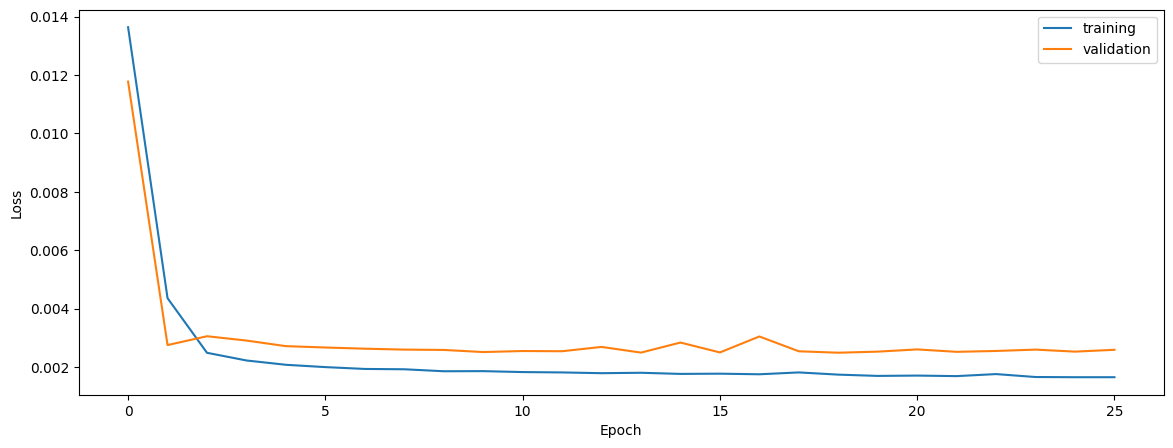

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


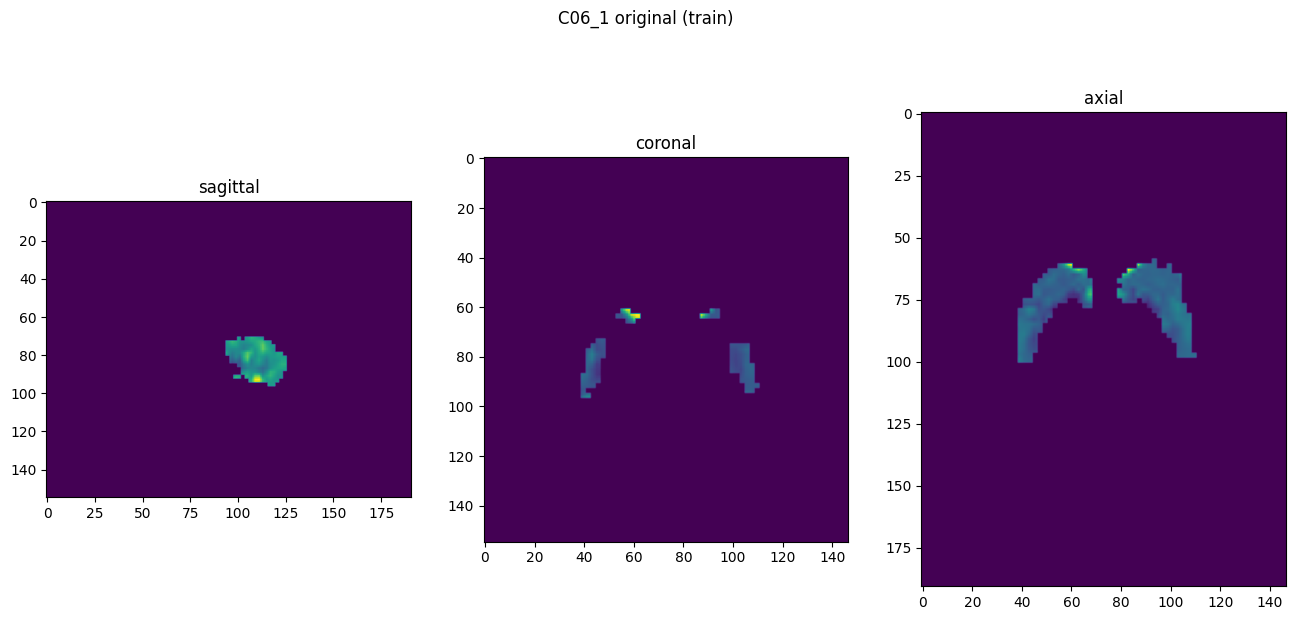

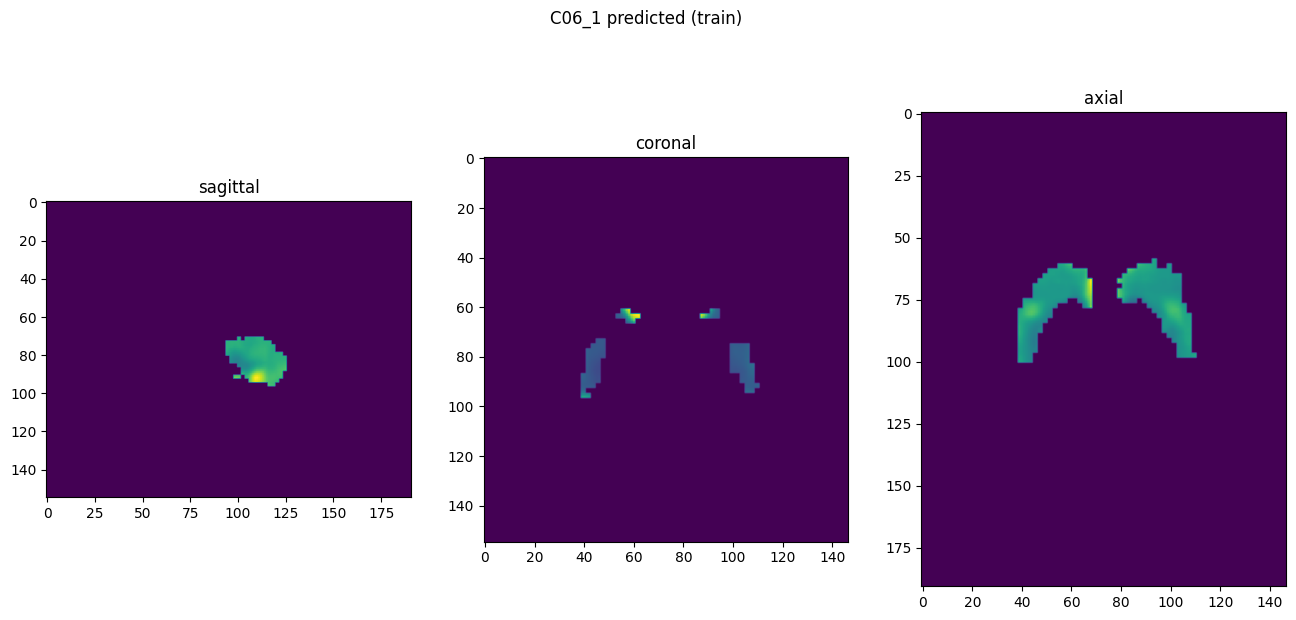

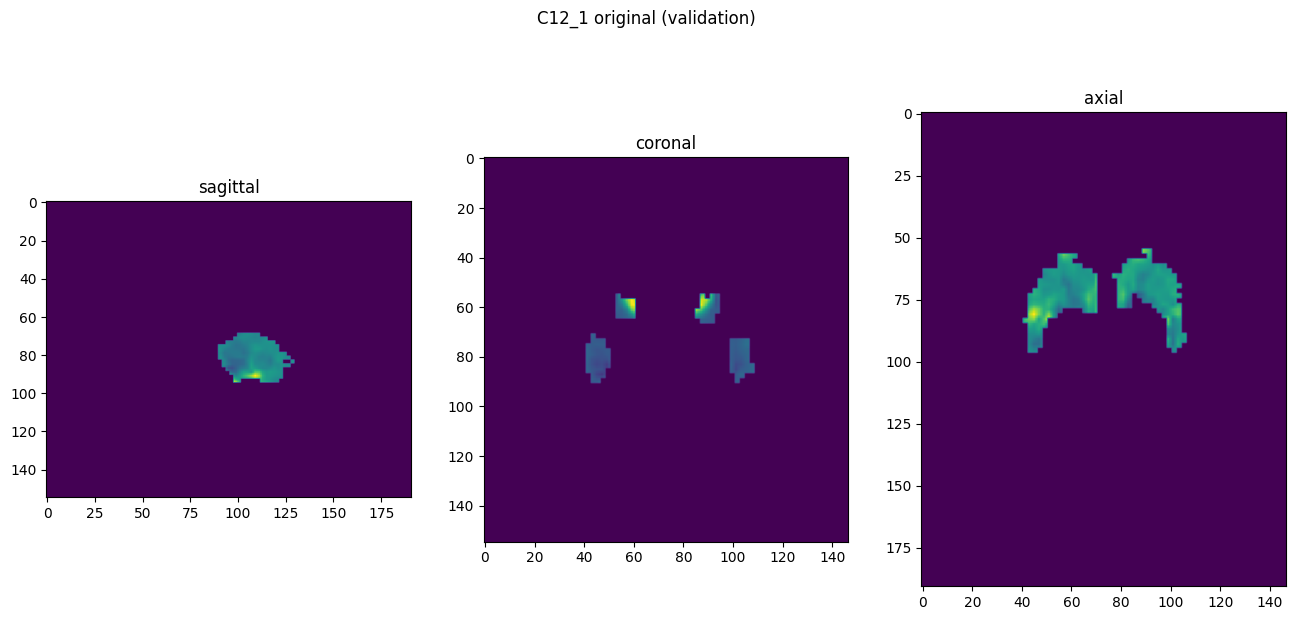

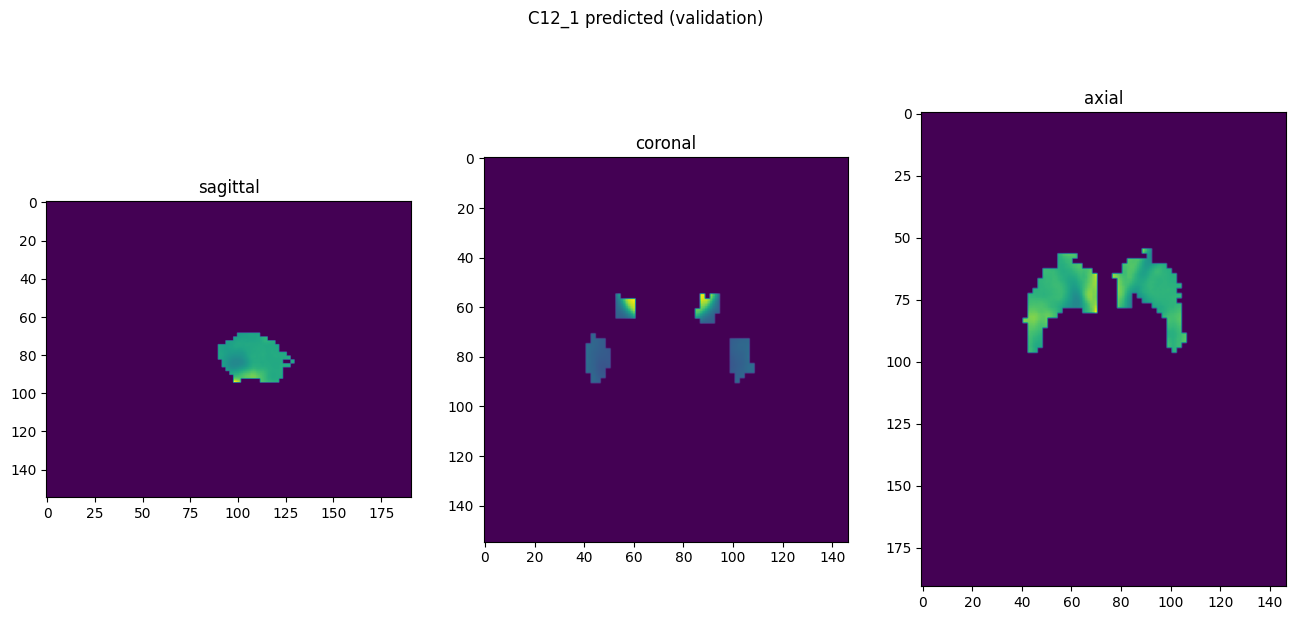

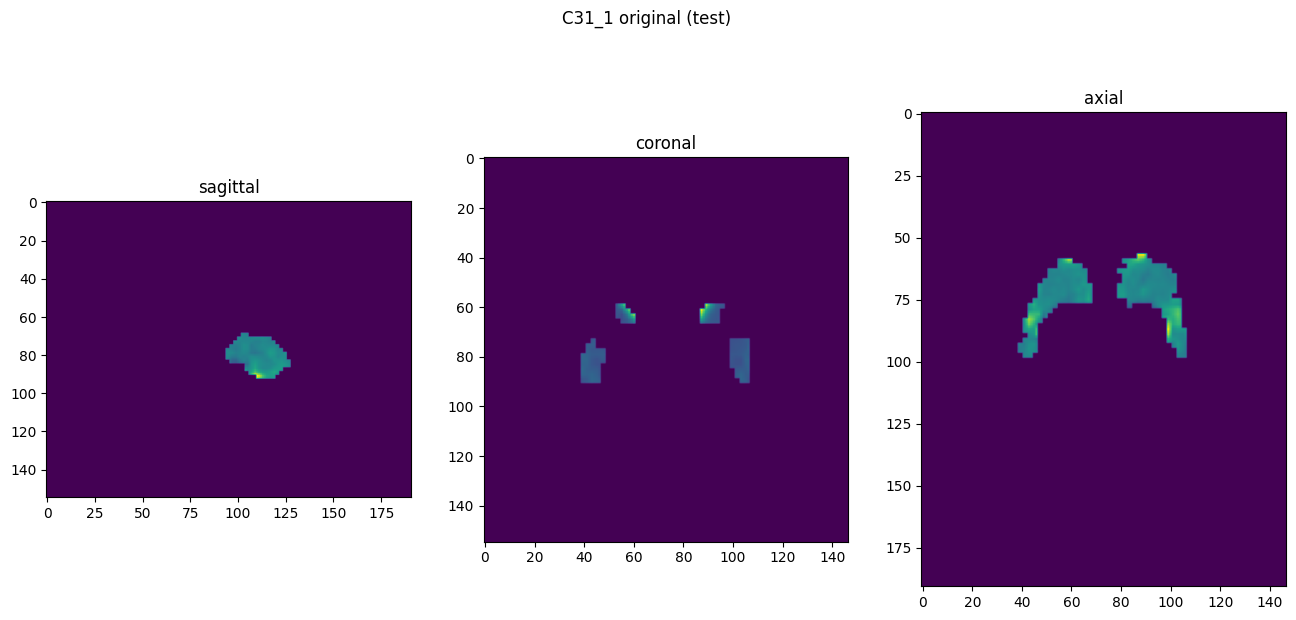

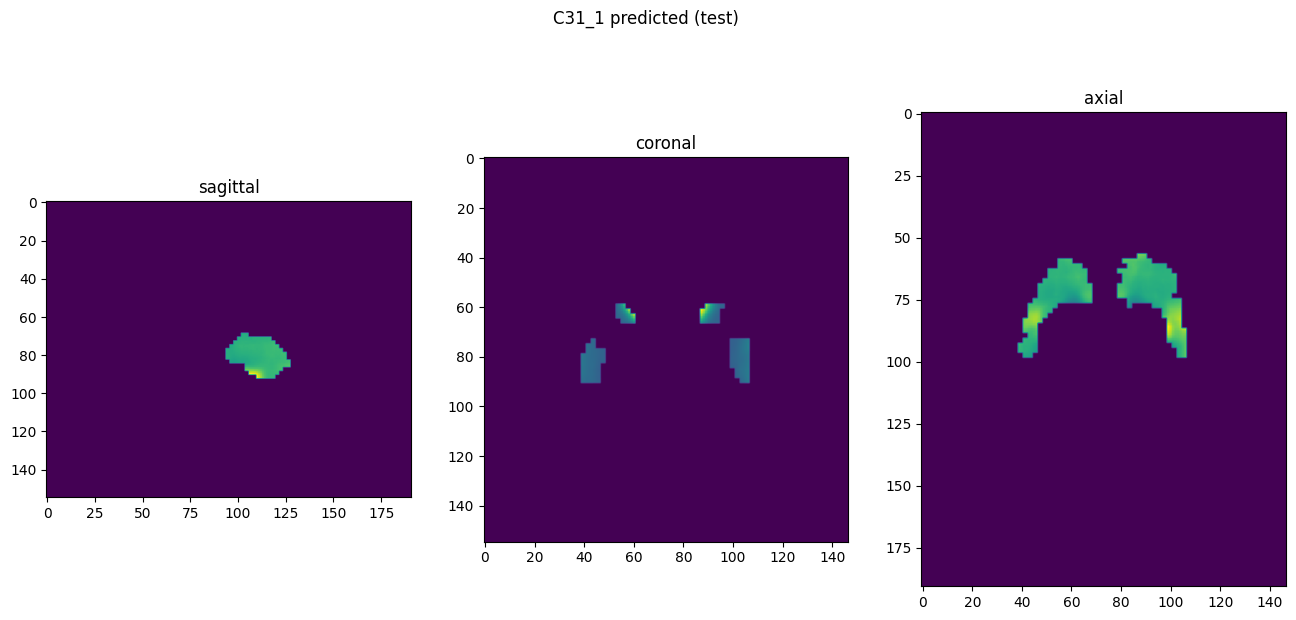

In [10]:
showResults(model, gen, threshold=None, background=False)